In [100]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math
from sklearn.metrics import mean_squared_error,mean_absolute_error,accuracy_score
import numpy as np
from keras.models import Sequential
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import r2_score
import seaborn as sns

In [1]:
import os

# Get the current working directory
current_directory = os.getcwd()

print("Current Working Directory:", current_directory)


Current Working Directory: C:\Users\Olayiwola\Desktop\Research\predictions\lstm


In [4]:
data=pd.read_csv("solar_pv_data.csv")

In [5]:
data.head()

,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month
0,2017-01-01 00:00:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.0,4,0,1
1,2017-01-01 00:15:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.0,4,0,1
2,2017-01-01 00:30:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.0,4,0,1
3,2017-01-01 00:45:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.0,4,0,1
4,2017-01-01 01:00:00,0,0.0,1.7,1020,100,5.2,0.0,0.0,100,0,0,450,0.0,4,1,1


# View data in any column of dataframe 

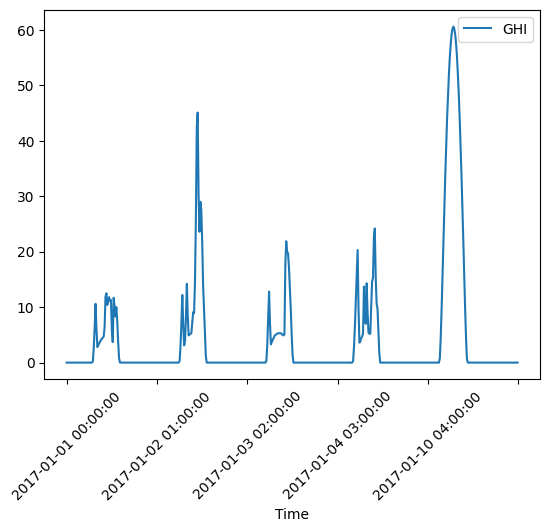

In [28]:
data_subset = data[:500]
data_subset.plot(x='Time',y='GHI')
plt.xticks(rotation=45)
plt.show()

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196776 entries, 0 to 196775
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Time                    196776 non-null  object 
 1   Energy delta[Wh]        196776 non-null  int64  
 2   GHI                     196776 non-null  float64
 3   temp                    196776 non-null  float64
 4   pressure                196776 non-null  int64  
 5   humidity                196776 non-null  int64  
 6   wind_speed              196776 non-null  float64
 7   rain_1h                 196776 non-null  float64
 8   snow_1h                 196776 non-null  float64
 9   clouds_all              196776 non-null  int64  
 10  isSun                   196776 non-null  int64  
 11  sunlightTime            196776 non-null  int64  
 12  dayLength               196776 non-null  int64  
 13  SunlightTime/daylength  196776 non-null  float64
 14  weather_type        

# Create a bar chart to visualize correlations with respect to Solar PV energy output

The plot bar below makes it easy to visualize factors that directly increase the value of solar PV output and the ones that reduce it.

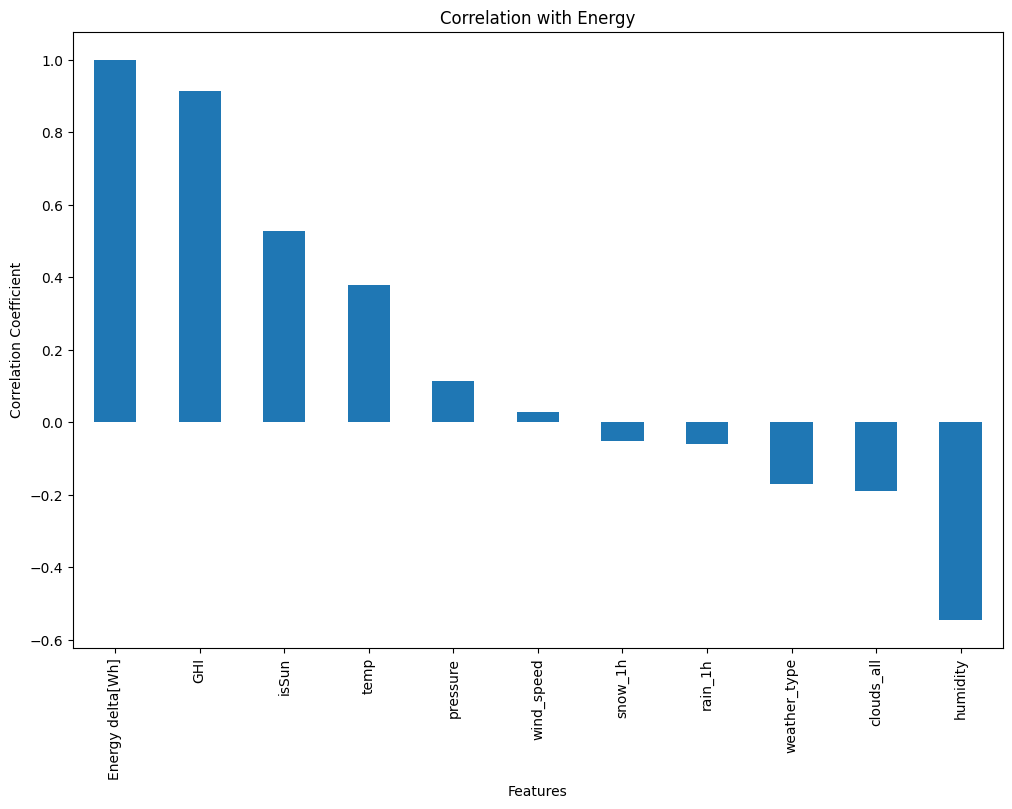

In [59]:
features_of_interest = ['Energy delta[Wh]', 'GHI', 'temp','pressure','humidity', 
                       'wind_speed', 'rain_1h', 'snow_1h', 'clouds_all', 'isSun', 'weather_type']

correlation_matrix = data[features_of_interest].corr()


plt.figure(figsize=(12, 8))
correlation_matrix['Energy delta[Wh]'].sort_values(ascending=False).plot(kind='bar')
plt.title('Correlation with Energy')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.show()

In [38]:
print(correlation_matrix)

                  wind_speed  Energy delta[Wh]       GHI      temp
wind_speed          1.000000          0.029385  0.017227 -0.080258
Energy delta[Wh]    0.029385          1.000000  0.914619  0.378554
GHI                 0.017227          0.914619  1.000000  0.492732
temp               -0.080258          0.378554  0.492732  1.000000


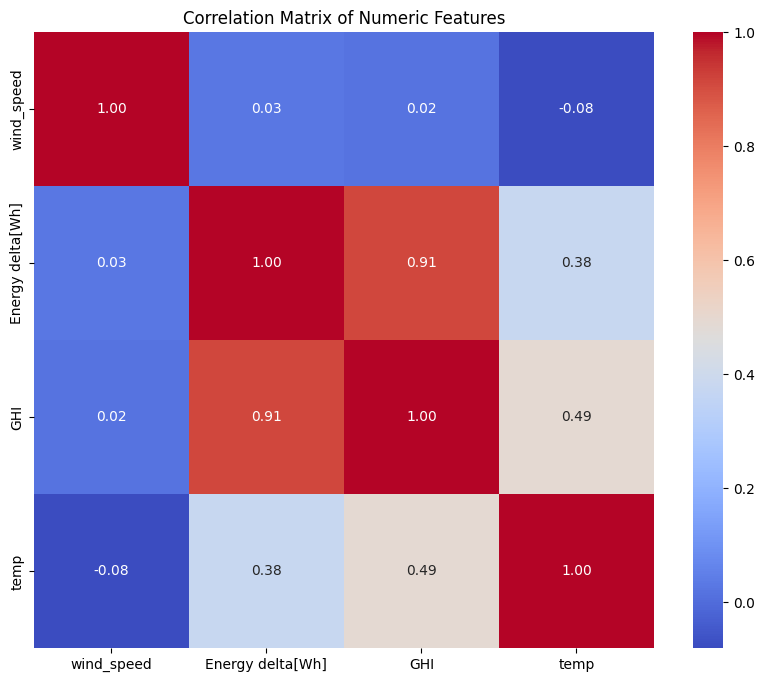

In [39]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [49]:
# Convert 'Time' to datetime if it's not already
data['Time'] = pd.to_datetime(data['Time'])

# Extract components
data['Year'] = data['Time'].dt.year
data['Month'] = data['Time'].dt.month
data['Day'] = data['Time'].dt.day
data['Hour'] = data['Time'].dt.hour
data['Minute'] = data['Time'].dt.minute


In [50]:
data.head()

,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,...,SunlightTime/daylength,weather_type,hour,month,Year,Month,Day,Hour,Minute,Second
0,2017-01-01 00:00:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,...,0.0,4,0,1,2017,1,1,0,0,0
1,2017-01-01 00:15:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,...,0.0,4,0,1,2017,1,1,0,15,0
2,2017-01-01 00:30:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,...,0.0,4,0,1,2017,1,1,0,30,0
3,2017-01-01 00:45:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,...,0.0,4,0,1,2017,1,1,0,45,0
4,2017-01-01 01:00:00,0,0.0,1.7,1020,100,5.2,0.0,0.0,100,...,0.0,4,1,1,2017,1,1,1,0,0


In [88]:
df=data.drop(columns=['Time','sunlightTime', 'dayLength', 'SunlightTime/daylength',
                     'hour', 'month', 'Year', 'Month', 'Day', 'Hour', 'Minute'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196776 entries, 0 to 196775
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   actual_energy  196776 non-null  int64  
 1   GHI            196776 non-null  float64
 2   temp           196776 non-null  float64
 3   pressure       196776 non-null  int64  
 4   humidity       196776 non-null  int64  
 5   wind_speed     196776 non-null  float64
 6   rain_1h        196776 non-null  float64
 7   snow_1h        196776 non-null  float64
 8   clouds_all     196776 non-null  int64  
 9   isSun          196776 non-null  int64  
 10  weather_type   196776 non-null  int64  
dtypes: float64(5), int64(6)
memory usage: 16.5 MB


In [58]:
print(data['weather_type'])

0         4
1         4
2         4
3         4
4         4
         ..
196771    3
196772    3
196773    3
196774    3
196775    3
Name: weather_type, Length: 196776, dtype: int64


In [91]:
df.rename(columns={'Energy delta[Wh]': 'actual_energy'}, inplace=True)

# Display the DataFrame to see the changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196776 entries, 0 to 196775
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   actual_energy  196776 non-null  int64  
 1   GHI            196776 non-null  float64
 2   temp           196776 non-null  float64
 3   pressure       196776 non-null  int64  
 4   humidity       196776 non-null  int64  
 5   wind_speed     196776 non-null  float64
 6   rain_1h        196776 non-null  float64
 7   snow_1h        196776 non-null  float64
 8   clouds_all     196776 non-null  int64  
 9   isSun          196776 non-null  int64  
 10  weather_type   196776 non-null  int64  
dtypes: float64(5), int64(6)
memory usage: 16.5 MB


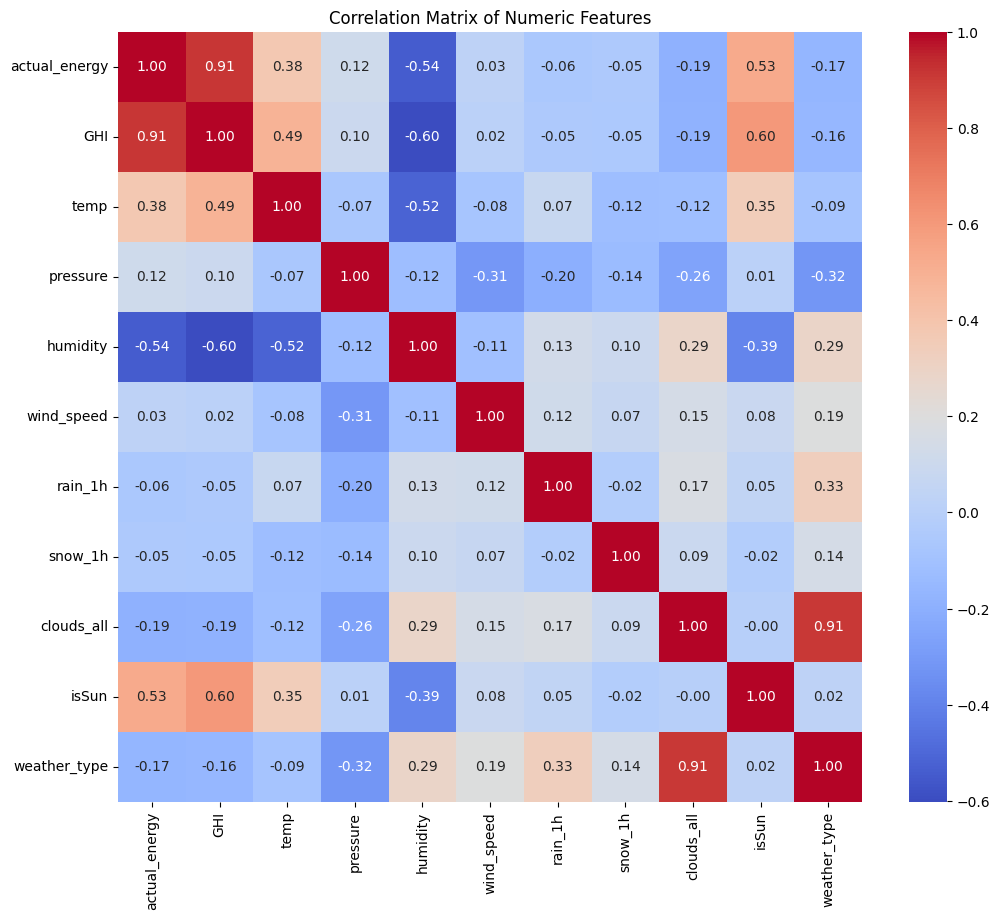

In [90]:
features_of_interest = ['actual_energy', 'GHI', 'temp','pressure','humidity', 
                       'wind_speed', 'rain_1h', 'snow_1h', 'clouds_all', 'isSun', 'weather_type']

correlation_matrix = df[features_of_interest].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [93]:
# Split the dataset into train and test sets
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

# Split the dataset based on indices (use iloc to split chronologically)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Separate features and target for training data
X_train = train_data.drop(columns=['actual_energy'])
y_train = train_data['actual_energy']

# Separate features and target for testing data 
X_test = test_data.drop(columns=['actual_energy'])
y_test = test_data['actual_energy']

#convert to NumPy arrays
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (157420, 10)
y_train shape: (157420,)
X_test shape: (39356, 10)
y_test shape: (39356,)


# Processing data to be fed into LSTM network

In [94]:
def sequential_form(input_data, output_data, prev_steps):

    X, y = list(), list()
    for i in range(input_data.shape[0]):
        end = i + prev_steps
        if end >= input_data.shape[0]:
            break
        seq_X = input_data[i:end]
        seq_y = output_data[end]
        X.append(seq_X)
        y.append(seq_y)
    x_seq = np.array(X)
    y_seq = np.array(y)
    return x_seq, y_seq

# LSTM

In [97]:
num_steps =2
# training set
(x_train_seq,
 y_train_seq) = sequential_form(X_train, y_train, prev_steps=num_steps)
assert x_train_seq.shape[0] == y_train_seq.shape[0]
# test set
(x_test_seq,
 y_test_seq) = sequential_form(X_test, y_test, prev_steps=num_steps)

In [99]:
from tensorflow.keras.layers import Input

lstm = Sequential()

# Add an Input layer to specify the shape of the input data
lstm.add(Input(shape=(2, 10)))

lstm.add(LSTM(units = 100, return_sequences = True))
lstm.add(Dropout(0.2))

#lstm.add(LSTM(units = 120, return_sequences = True))
#lstm.add(Dropout(0.25))

lstm.add(LSTM(units = 64, return_sequences = True))
lstm.add(Dropout(0.25))

lstm.add(LSTM(units = 56))
lstm.add(Dropout(0.25))



lstm.add(Dense(units = 1))

lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

trained_model=lstm.fit(x_train_seq, y_train_seq, epochs = 50, batch_size = 10)

Epoch 1/50
7871/7871 [==============================] - 120s 15ms/step - loss: 1242688.3750
Epoch 2/50
7871/7871 [==============================] - 117s 15ms/step - loss: 1049815.1250
Epoch 3/50
6465/7871 [=======================>......] - ETA: 22s - loss: 782130.7500

KeyboardInterrupt: 

In [ ]:
lstm.summary()

In [ ]:
prediction=lstm.predict(x_test_seq)

In [ ]:
plt.plot(trained_model.history['loss'])
# plt.plot(trained_model.history['val_loss'])
# plt.plot(trained_model.history['mean_absolute_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
if prediction.ndim > 1:
    prediction = prediction.reshape(-1)

if y_test.ndim > 1:
    y_test = y_test.reshape(-1)

# Plotting
plt.figure(figsize=(14, 7))

# Plot the actual values
plt.plot(y_test[200:400], label='Actual Values', color='blue')

# Plot the predictions
plt.plot(prediction[200:400], label='Predictions', color='red', linestyle='--')

# Add titles and labels
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
rmse_LSTM= (mean_squared_error(y_test[2:],prediction))
print(rmse_LSTM)

# Normalized rmse

In [ ]:
rrmse_LSTM = rmse_LSTM / y_test[2:].mean()
print(rrmse_LSTM)
range_y_test = df['actual_energy'].max() - df['actual_energy'].min()
nrmse_LSTM = rmse_LSTM / range_y_test
print(nrmse_LSTM)

In [ ]:
r2 = r2_score(y_test[2:],prediction)
print('r2 score for this model is', r2)

In [ ]:
mae_lstm = mean_absolute_error(y_test[2:],prediction)
print('mae for this model is',mae_lstm)